# Testing: Mitigating algorithmic unfairness with the MADD

We test maddlib on an example use case with some data and a random model.. The initial distributions do not need much mitigation.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../'))
from maddlib import evaluation
from maddlib import optimal_bandwidth
from maddlib.postprocessing import postprocessing_tools
from maddlib.postprocessing import distribution_tools

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression

## 0. Preliminaries

### 0.1. Get data

In [3]:
# Load train and test sets
X_train = pd.read_csv("./data/X_train.csv")
X_test = pd.read_csv("./data/X_test.csv")
y_train = pd.read_csv("./data/y_train.csv")
y_test = pd.read_csv("./data/y_test.csv")

### 0.2. Train a model

In [4]:
# Training phase: Fit a classifier
clf = LogisticRegression(random_state=0)
clf.fit(X_train, y_train.values.ravel())

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,0
,solver,'lbfgs'
,max_iter,100
,multi_class,'deprecated'


### 0.3. Get the predicted probabilities

In [5]:
# Testing phase: Get the predicted probabilities of positive predictions
y_pp = clf.predict_proba(X_test)[:, 1] 

## 1. Post-processing

### 1.1. Plot initial distributions

In [6]:
# Choose two distincts groups
sensitive_feature = "poverty"
compar_groups = ("Not poor", "Poor")

In [7]:
# Get the respective predicted probabilities
y_pp0, y_pp1 = evaluation.separate_pred_proba(X_test, y_pp, sensitive_feature)

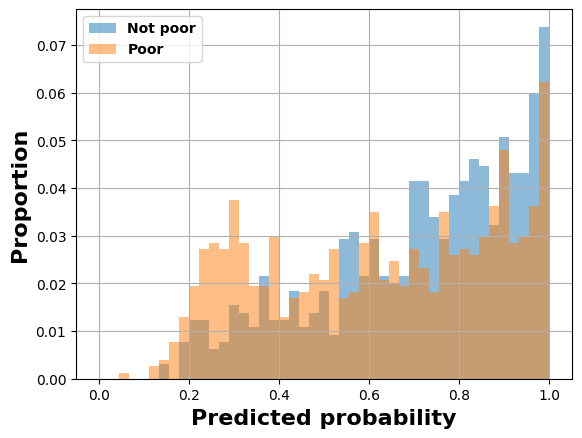

In [8]:
# Calculate number of bins of the histograms
n0 = len(y_pp0)
n1 = len(y_pp1)
nb_bins = int((n0/(n0+n1))*100)

# Plot the two distribution histograms
distribution_tools.plot_histograms(y_pp0, y_pp1, nb_bins, compar_groups)

### 1.2. Post-process the distributions

In [9]:
results = postprocessing_tools.post_processing_fixed_theta(y_pp0, y_pp1, y_pp, nb_bins=nb_bins,
                                                           theta=0.5, loss_type='accuracy_percentage', real_madd=True,
                                                           auto_rescale=False, seuil=0.5)

Calculating: 100%|████████████████████| 1000/1000 [00:05<00:00, 186.74it/s]


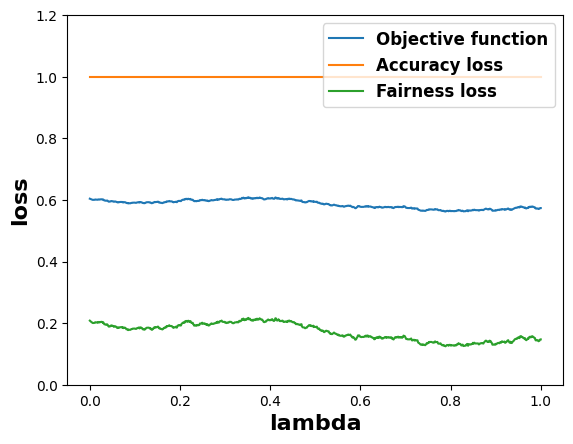

In [10]:
# Plot the effet of lambda on the objective function, accuracy loss and fairness loss
postprocessing_tools.plot_func_2D(Lambda = np.linspace(0, 1, 1000), total_loss=results['total_loss'], 
                                  accu_loss = results['accu_loss'], madd=0.5*results['madd'], 
                                  ylim=[0, 1.2])

In [11]:
# Compute new predicted probabilities after post-processing
y_pp_improved = postprocessing_tools.fair_improved_predicton(data=results, lambda_=0.798)
new_y_pp0, new_y_pp1 = y_pp_improved[:n0], y_pp_improved[n1:]

### 1.3. Plot new distributions

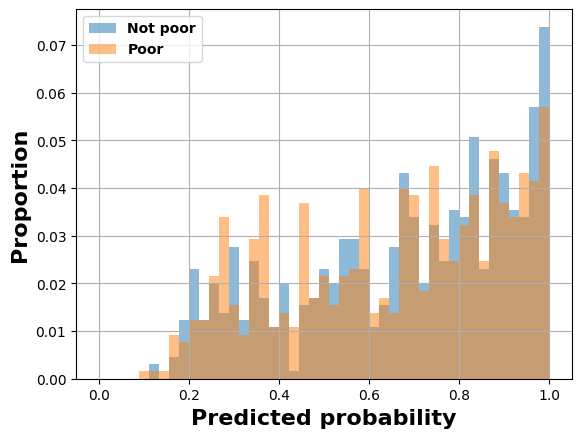

In [12]:
distribution_tools.plot_histograms(new_y_pp0, new_y_pp1, nb_bins, compar_groups)